# Analysis of ballot position
[Brian C. Keegan, Ph.D.](http://www.brianckeegan.com)  
October 2022

Released under a [MIT License](https://opensource.org/licenses/MIT).

Import libraries.

In [16]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

idx = pd.IndexSlice

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sb

import json

Open data.

In [6]:
# Precincts within the City of Boulder -- cast ballots for City Council
with open('../2021 election/cob_precincts.json','r') as f:
    cob_precincts = json.load(f)

In [7]:
# Load cleaned precinct-level election data for 2012-2021
sov_df = pd.read_csv('../Data/Elections/all-election-cleaned-sov.csv')

# Clean up fields that are inconsistently named across elections
sov_df.replace({'Contest Name':{'City Of Boulder Council Candidates':'City of Boulder Council Candidates'}},inplace=True)
sov_df.replace({'Party':{'DEM':'Democratic','REP':'Republican','LBR':'Libertarian','GRN':'Green'}},inplace=True)

# Rename values in Party column for 2016
c_2016_dem = sov_df['Choice Name'] == 'Hillary Clinton / Tim Kaine'
c_2016_rep = sov_df['Choice Name'] == 'Donald J. Trump / Michael R. Pence'
sov_df.loc[c_2016_dem,'Party'] = sov_df.loc[c_2016_dem,'Choice Name'].map({'Hillary Clinton / Tim Kaine':'Democratic'})
sov_df.loc[c_2016_rep,'Party'] = sov_df.loc[c_2016_rep,'Choice Name'].map({'Donald J. Trump / Michael R. Pence':'Republican'})

# Inspect
sov_df.head()

/var/folders/lr/v195xr617d32k2zdwwh30sb40000gn/T/ipykernel_94306/2431307678.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  sov_df = pd.read_csv('../Data/Elections/all-election-cleaned-sov.csv')


,Year,Active Voters,Total Ballots,Contest Name,Choice Name,Total Votes,Party,Precinct Name
0,2012,1369,1032,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2163307100
1,2012,1369,1040,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2163307101
2,2012,1787,857,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2163307102
3,2012,1186,954,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,1,American,2163307103
4,2012,1197,953,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2163307104


Filter precincts to City of Boulder precincts.

In [8]:
c = sov_df['Precinct Name'].isin(cob_precincts)
cob_sov_df = sov_df.loc[c,:]

Identify contests that were not city-wide (local improvement districts, *etc*.).

In [9]:
incomplete_contests = {}

for year in range(2012,2022):
    pivot_df = pd.pivot_table(
        data = cob_sov_df[cob_sov_df['Year'] == year],
        index = 'Precinct Name',
        columns = ['Contest Name'],
        values = 'Total Votes',
        aggfunc = np.nansum
    )

    pivot_filter_df = pivot_df.isnull().sum().sort_values()
    incomplete_contests[year] = list(pivot_filter_df[pivot_filter_df > 2].index)

incomplete_contest_l = set([j for i in incomplete_contests.values() for j in i])

cob_complete_sov_df = cob_sov_df[~cob_sov_df['Contest Name'].isin(incomplete_contest_l)]

Compute ballot position.

In [10]:
cob_sov_pos_l = []
for _year in cob_sov_df['Year'].unique():
    _position_mapping = dict(enumerate(cob_complete_sov_df.loc[cob_complete_sov_df['Year'] == _year,'Contest Name'].unique()))
    _position_mapping = {v:k+1 for k,v in _position_mapping.items()}
    _df = cob_complete_sov_df.copy().loc[cob_complete_sov_df['Year'] == _year]
    _df['Position'] = _df['Contest Name'].map(_position_mapping)
    cob_sov_pos_l.append(_df)
    
cob_sov_pos_df = pd.concat(cob_sov_pos_l)

cob_sov_pos_df.head()

,Year,Active Voters,Total Ballots,Contest Name,Choice Name,Total Votes,Party,Precinct Name,Position
125,2012,972,781,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2181007800,1
126,2012,588,472,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2181007801,1
127,2012,1052,640,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2181007802,1
129,2012,1434,1175,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2181007804,1
131,2012,1272,933,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,1,American,2181007806,1


Identify contests where there is less than two choices.

In [11]:
multichoice_contests = cob_sov_pos_df.groupby(['Year','Contest Name']).agg({'Choice Name':'nunique'})['Choice Name']
multichoice_contests = (multichoice_contests < 2).reset_index()
multichoice_contests.rename(columns={'Choice Name':'Multichoice'},inplace=True)
multichoice_contests.head()

,Year,Contest Name,Multichoice
0,2012,Amendment 64 (Constitutional),False
1,2012,Amendment 65 (Constitutional),False
2,2012,Amendment S (Constitutional),False
3,2012,City Of Boulder Ballot Issue No. 2A,False
4,2012,City Of Boulder Ballot Issue No. 2B,False


## Voting behavior

How have Boulder voters selected Democratic candidates in the past?

In [12]:
contest_party_pivot_df = pd.pivot_table(
    data = cob_sov_pos_df,
    index = ['Year','Contest Name'],
    columns = 'Party',
    values = 'Total Votes',
    aggfunc = 'sum'
)

dem_voteshare = contest_party_pivot_df.loc[:,'Democratic'] / contest_party_pivot_df.sum(1)
dem_voteshare.describe()

count    46.000000
mean      0.876770
std       0.084993
min       0.749542
25%       0.808237
50%       0.850037
75%       0.999567
max       1.000000
dtype: float64

## Turnout by election
Calculate contest-level statistics.

In [13]:
# Group by year, precinct, and contest and calculate statistics
agg_d = {'Total Votes':'sum','Active Voters':'max','Total Ballots':'max','Position':'max'}
cob_precinct_turnout = cob_sov_pos_df.groupby(['Year','Precinct Name','Contest Name']).agg(agg_d)
cob_precinct_turnout.reset_index(inplace=True)

# City council races 
c0 = cob_precinct_turnout['Contest Name'] == 'City of Boulder Council Candidates'
cob_precinct_turnout.loc[c0,'Total Votes'] = cob_precinct_turnout.loc[c0,'Total Votes'] / 5

# Calculate turnout
cob_precinct_turnout['Turnout'] = cob_precinct_turnout['Total Votes'] / cob_precinct_turnout['Active Voters']

# Odd/even
cob_precinct_turnout['Odd'] = (cob_precinct_turnout['Year'] % 2).astype(bool)

# Inspect
cob_precinct_turnout.head()

,Year,Precinct Name,Contest Name,Total Votes,Active Voters,Total Ballots,Position,Turnout,Odd
0,2012,2181007800,Amendment 64 (Constitutional),757.0,972,781,20,0.778807,False
1,2012,2181007800,Amendment 65 (Constitutional),725.0,972,781,21,0.745885,False
2,2012,2181007800,Amendment S (Constitutional),679.0,972,781,19,0.698560,False
3,2012,2181007800,County Commissioner - District 1,605.0,972,781,7,0.622428,False
4,2012,2181007800,County Commissioner - District 2,692.0,972,781,8,0.711934,False


In [18]:
# Calculate number of contests by year
_df1 = cob_sov_pos_df.groupby('Year').agg({'Contest Name':'nunique'})

# Calculate turnout values by year
_df2 = cob_sov_pos_df.groupby(['Year','Contest Name','Choice Name']).agg(
    {'Total Ballots':'sum','Active Voters':'sum'}
).groupby(level=[0]).max()

# Join together
election_stats = pd.concat([_df1,_df2],axis=1)
election_stats['Turnout'] = election_stats['Total Ballots'] / election_stats['Active Voters']

# Identify odd/even year elections
election_stats['Odd'] = election_stats.index % 2
election_stats['Odd'] = election_stats['Odd'].apply(bool)

election_stats

,Contest Name,Total Ballots,Active Voters,Turnout,Odd
Year,,,,,
2012,25,66921,100991,0.662643,False
2013,12,35096,74623,0.470311,True
2014,38,49874,68812,0.724786,False
2015,14,31442,67188,0.467970,True
2016,40,68926,77394,0.890586,False
2017,13,33652,77304,0.435320,True
2018,47,61273,74212,0.825648,False
2019,11,37247,73349,0.507805,True
2020,34,67338,75007,0.897756,False


Visualizing relationship between contests and turnout.

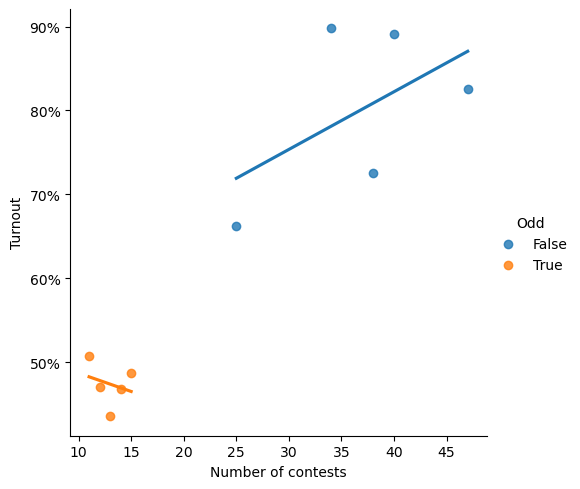

In [20]:
sb.lmplot(
    data = election_stats,
    x = 'Contest Name',
    y = 'Turnout',
    hue = 'Odd',
    ci = 0
)

plt.xlabel('Number of contests')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.savefig('turnout_by_contest_number.png',facecolor='white')

## Turnout by ballot position

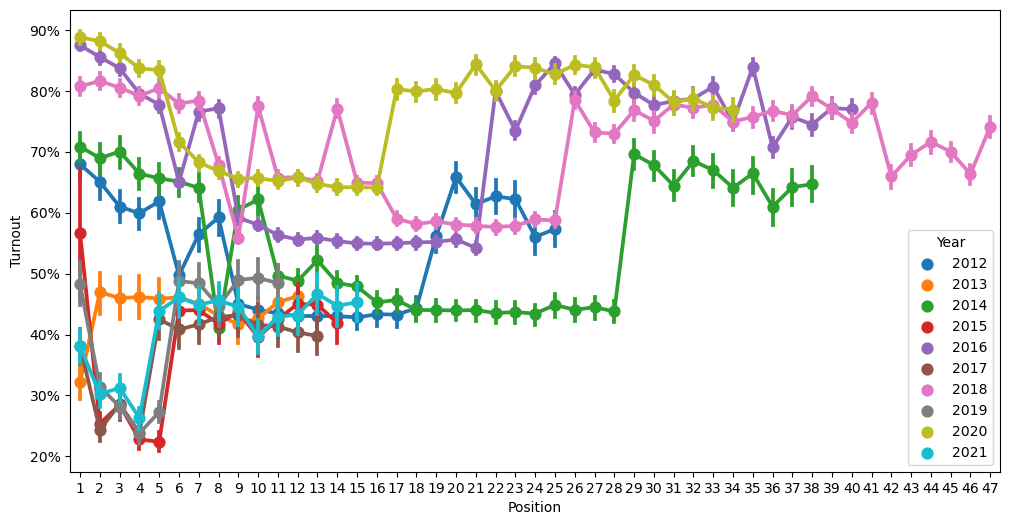

In [21]:
f,ax = plt.subplots(figsize=(12,6))
sb.pointplot(
    data = cob_precinct_turnout,
    x = 'Position',
    y = 'Turnout',
    hue = 'Year',
    ax = ax
)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.savefig('turnout_by_position.png',facecolor='white')

Correlations between position and turnout.

In [22]:
# Odd years
cob_precinct_turnout.loc[cob_precinct_turnout['Odd'],['Position','Turnout']].corr().iloc[0,1]

0.20280444445125825

In [23]:
# Even years
cob_precinct_turnout.loc[~cob_precinct_turnout['Odd'],['Position','Turnout']].corr().iloc[0,1]

0.12990567391127728

Plot precinct-level turnout by ballot position.

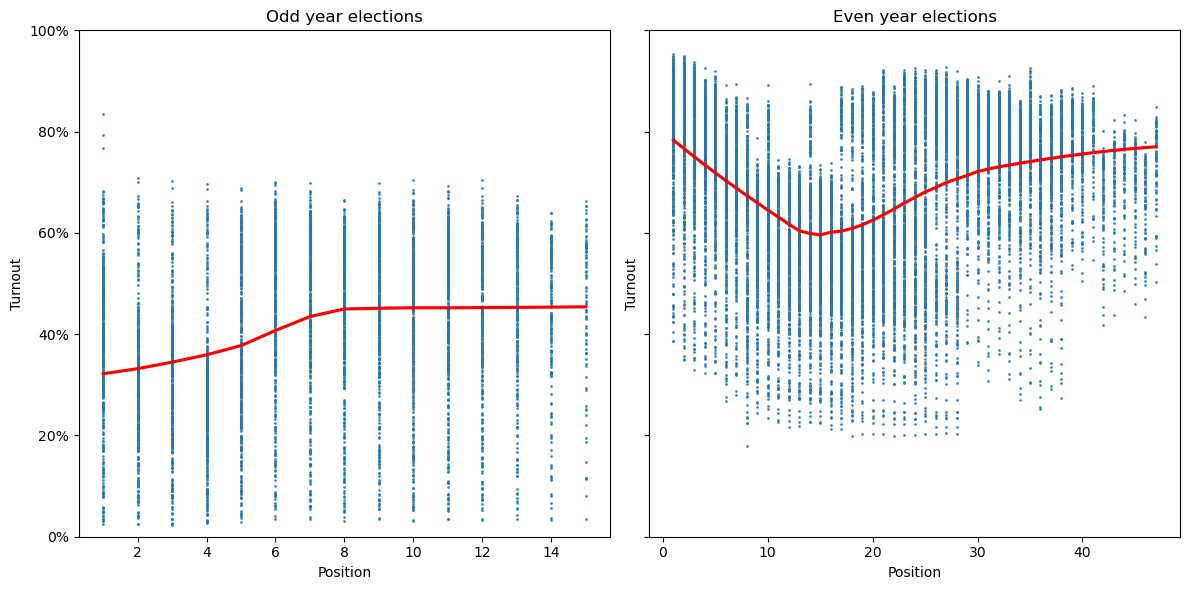

In [24]:
f,axs = plt.subplots(1,2,figsize=(12,6),subplot_kw={'ylim':(0,1)},sharey=True)

sb.regplot(
    data = cob_precinct_turnout[cob_precinct_turnout['Odd']],
    x = 'Position',
    y = 'Turnout',
    ax = axs[0],
    scatter_kws = {'s':1},
    line_kws = {'color':'red'},
    lowess = True
)

sb.regplot(
    data = cob_precinct_turnout[~cob_precinct_turnout['Odd']],
    x = 'Position',
    y = 'Turnout',
    ax = axs[1],
    scatter_kws = {'s':1},
    line_kws = {'color':'red'},
    lowess = True
)

axs[0].set_title('Odd year elections')
axs[1].set_title('Even year elections')

axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))

f.tight_layout()
f.savefig('turnout_by_position_odd_even.png',facecolor='white')

## Predictability of contests

Import statistical models.

In [25]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import get_scorer_names

from sklearn.model_selection import cross_val_score

Reshape data.

In [50]:
precinct_contest_winner_d = {}

for year in range(2012,2022):
    _pivot = pd.pivot_table(
        data = cob_sov_pos_df[cob_sov_pos_df['Year'] == year],
        index = ['Precinct Name'],
        columns = ['Contest Name','Choice Name'],
        values = 'Total Votes'
    )

    _ix = cob_sov_pos_df[cob_sov_pos_df['Year'] == year].groupby(['Contest Name','Choice Name']).agg({'Total Votes':'sum'}).groupby(level=[0]).idxmax()['Total Votes']

    _df = _pivot / _pivot.sum(axis=1,level=0)
    precinct_contest_winner_d[year] = _df.loc[:,_ix].fillna(0)

/var/folders/lr/v195xr617d32k2zdwwh30sb40000gn/T/ipykernel_94306/400362339.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  _df = _pivot / _pivot.sum(axis=1,level=0)
/var/folders/lr/v195xr617d32k2zdwwh30sb40000gn/T/ipykernel_94306/400362339.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  _df = _pivot / _pivot.sum(axis=1,level=0)
/var/folders/lr/v195xr617d32k2zdwwh30sb40000gn/T/ipykernel_94306/400362339.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  _df = _pivot / _pivot.sum(axis=1,level=0)
/var

Estimate models.

In [28]:
rf = RandomForestRegressor(n_jobs=-1)
ab = AdaBoostRegressor()
gb = GradientBoostingRegressor()
lr = LinearRegression(n_jobs=-1)

scores_d = {}

# For each year
for year,_df in precinct_contest_winner_d.items():
    scores_d[year] = {}
    
    _columns = _df.columns
    
    # For each contest
    for col in _columns:
        scores_d[year][col] = {}
        
        _X_cols = list(set(_columns) - set(col))
        
        # For each estimator
        for _estimator in [rf,ab,gb,lr]:
            
            _name = _estimator.__class__.__name__
            
            scores_d[year][col][_name] = cross_val_score(
                estimator = _estimator,
                X = _df.loc[:,_X_cols],
                y = _df.loc[:,col],
                scoring = 'r2',
                cv=5).mean()

Reshape scores data.

In [29]:
# Load data from dictionary
scores_df = pd.DataFrame.from_dict(scores_d,orient='index').stack([0,1]).apply(pd.Series)
scores_df.index = scores_df.index.droplevel(2)

# Ignore overfitted linear regression
scores_df.drop(columns=['LinearRegression'],inplace=True)

# Reshape and cleanup
scores_df = pd.DataFrame(scores_df.stack())
scores_df['Position'] = cob_sov_pos_df.groupby(['Year','Contest Name']).agg({'Position':'max'})
scores_df.reset_index(inplace=True)
scores_df.columns = ['Year','Contest Name','Estimator','Score','Position']

# Differentiate odd/even elections
scores_df['Odd'] = (scores_df['Year'] % 2).apply(bool)

# Inspect
scores_df.head()

,Year,Contest Name,Estimator,Score,Position,Odd
0,2012,Amendment 64 (Constitutional),RandomForestRegressor,0.982447,20,False
1,2012,Amendment 64 (Constitutional),AdaBoostRegressor,0.983763,20,False
2,2012,Amendment 64 (Constitutional),GradientBoostingRegressor,0.989496,20,False
3,2012,Amendment 65 (Constitutional),RandomForestRegressor,0.975619,21,False
4,2012,Amendment 65 (Constitutional),AdaBoostRegressor,0.983796,21,False


Plot model performance by position.

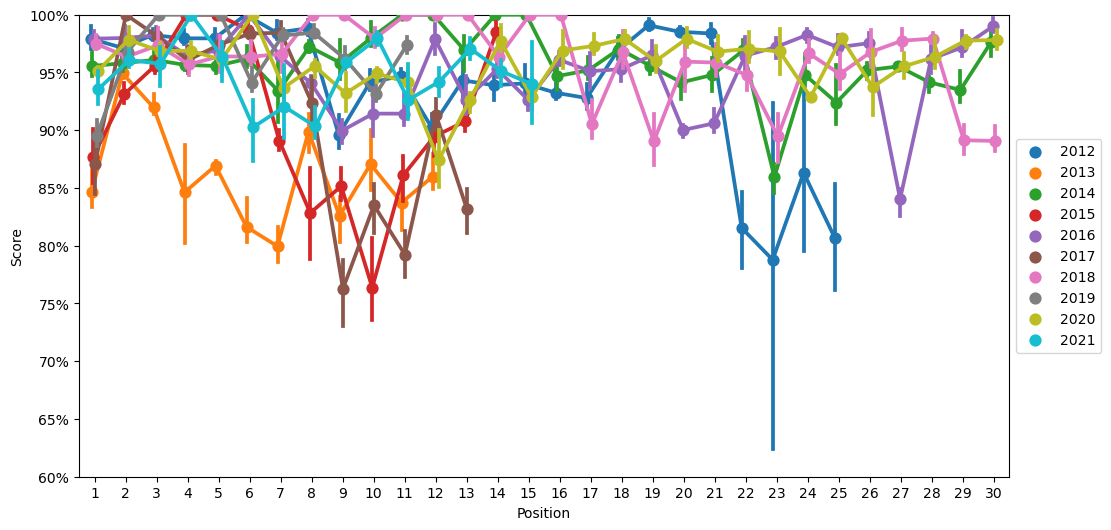

In [48]:
f,ax = plt.subplots(figsize=(12,6))

sb.pointplot(
    data = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)],
    x = 'Position',
    y = 'Score',
    hue = 'Year',
    ax = ax,
    dodge = .25
)

ax.set_ylim((.6,1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.legend(loc='center left',bbox_to_anchor=(1,.5))

Aggregate to odd and even years.

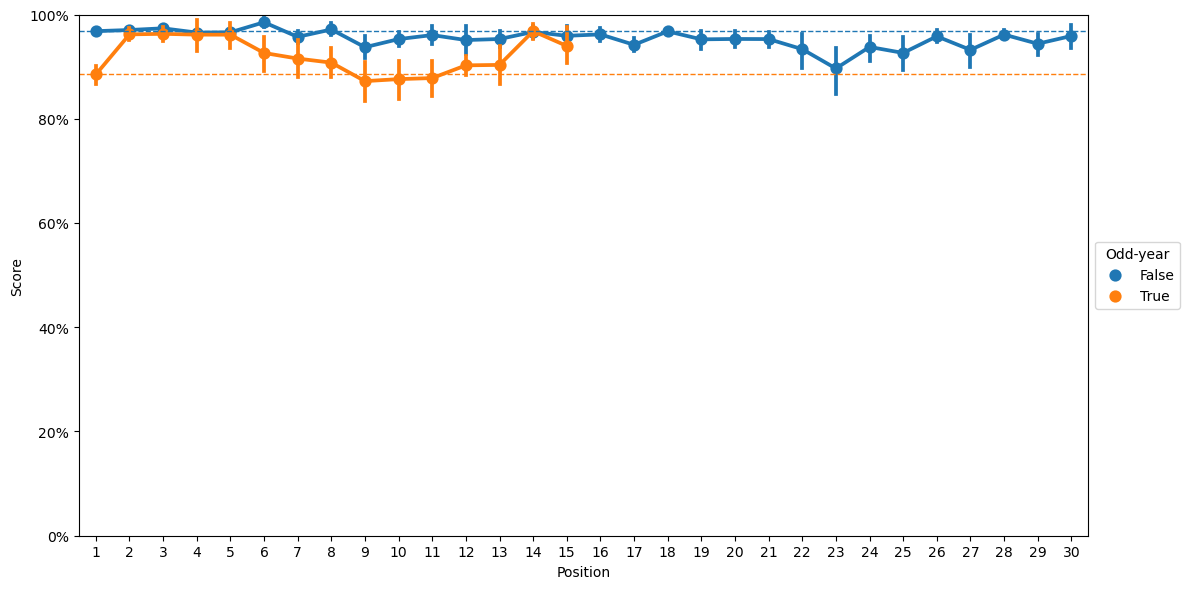

In [39]:
f,ax = plt.subplots(figsize=(12,6))

sb.pointplot(
    data = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)],
    x = 'Position',
    y = 'Score',
    hue = 'Odd',
    ax = ax
)

ax.set_ylim((0,1))
ax.legend(loc='center left',bbox_to_anchor=(1,.5),title='Odd-year')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

even_pos_1_mean = scores_df.loc[~scores_df['Odd'] & (scores_df['Position'] == 1),'Score'].mean()
odd_pos_1_mean = scores_df.loc[scores_df['Odd'] & (scores_df['Position'] == 1),'Score'].mean()
ax.axhline(even_pos_1_mean,lw=1,ls='--',color='tab:blue')
ax.axhline(odd_pos_1_mean,lw=1,ls='--',color='tab:orange')

f.tight_layout()
f.savefig('predictability_position.png',facecolor='white',bbox_inches='tight')

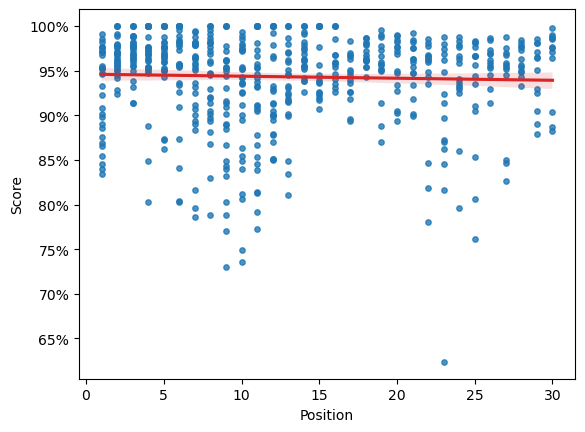

In [43]:
ax = sb.regplot(
    data = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)],
    x = 'Position',
    y = 'Score',
    scatter_kws = {'s':15},
    line_kws= {'color':'tab:red'}
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

Compute correlation.

In [318]:
_df = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)]
_df[['Score','Position']].corr().iloc[0,1]

-0.03911028724739549